In [21]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B1
import os
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
%matplotlib inline

In [7]:

# Параметры
img_height, img_width = 224, 224
batch_size = 1
test_path = '/kaggle/input/binary-coco-first-article/test'


In [8]:
# Функция для создания модели
def make_model():
    ENV2_B1 = EfficientNetV2B1(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3),
        include_preprocessing=True
    )
    ENV2_B1.trainable = False

    model1 = Sequential()
    model1.add(Input(shape=(img_height, img_width, 3)))
    model1.add(ENV2_B1)
    model1.add(Flatten())
    model1.add(Dense(512, activation='relu'))
    model1.add(Dropout(0.25))
    model1.add(Dense(64, activation='relu'))
    model1.add(Dropout(0.25))
    model1.add(Dense(2, activation='softmax'))

    model1.compile(loss='sparse_categorical_crossentropy',
                   optimizer="nadam",
                   metrics=['accuracy'])

    return model1



In [9]:
# Создаем и загружаем модель
model1 = make_model()
model1.summary()
model1.load_weights('/kaggle/input/efectnwt_20/keras/default/1/model_last.keras')


28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)  │ (None, 7, 7, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,077,238 (149.07 MB)

 Trainable params: 32,146,114 (122.63 MB)

 Non-trainable params: 6,931,124 (26.44 MB)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 15 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:

# Создание тестового набора данных
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)


Found 80 files belonging to 2 classes.


In [11]:
# Функция для форматирования результатов
def format_result(img_path, true_class, pred_class, pred_probs, time_info):
    class_names = {0: 'healthy', 1: 'unhealthy'}
    true_label = class_names[true_class]
    pred_label = class_names[pred_class]
    confidence = pred_probs[pred_class]
    pred_probs_str = ', '.join([f'{class_names[i]} {prob:.2f}' for i, prob in enumerate(pred_probs)])
    return (f'image {img_path}: {img_height}x{img_width} {pred_label} {confidence:.2f}, '
            f'{pred_probs_str}, {time_info}ms')




In [12]:
# Перебор всех изображений в тестовом наборе данных
results_list = []
start_time = time.time()

for img_batch, labels_batch in test_ds:
    start_preprocess = time.time()
    
    # Извлекаем путь изображения
    img_path = test_ds.file_paths[0]
    true_class = labels_batch.numpy()[0]
    
    # Выполнение инференса
    start_inference = time.time()
    pred_probs = model1.predict(img_batch)[0]
    pred_class = np.argmax(pred_probs)
    end_inference = time.time()
    
    # Форматирование результатов
    preprocess_time = (start_inference - start_preprocess) * 1000  # время в мс
    inference_time = (end_inference - start_inference) * 1000  # время в мс
    total_time = (end_inference - start_preprocess) * 1000  # общее время в мс
    
    time_info = f'{preprocess_time:.1f}ms preprocess, {inference_time:.1f}ms inference, {total_time:.1f}ms total'
    
    result_str = format_result(img_path, true_class, pred_class, pred_probs, time_info)
    print(result_str)
    
    results_list.append({
        'Image': img_path,
        'TrueClass': true_class,
        'PredClass': pred_class,
        'Confidence': pred_probs[pred_class]
    })


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
image /kaggle/input/binary-coco-first-article/test/unhealthy/a7e0d6cf-82f9-46db-b083-0066cb91ddaf.2.jpg: 224x224 unhealthy 1.00, healthy 0.00, unhealthy 1.00, 0.1ms preprocess, 3981.6ms inference, 3981.7ms totalms
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
image /kaggle/input/binary-coco-first-article/test/unhealthy/a7e0d6cf-82f9-46db-b083-0066cb91ddaf.2.jpg: 224x224 healthy 1.00, healthy 1.00, unhealthy 0.00, 0.1ms preprocess, 191.5ms inference, 191.5ms totalms
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
image /kaggle/input/binary-coco-first-article/test/unhealthy/a7e0d6cf-82f9-46db-b083-0066cb91ddaf.2.jpg: 224x224 unhealthy 1.00, healthy 0.00, unhealthy 1.00, 0.0ms preprocess, 191.3ms inference, 191.3ms totalms
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
image /kaggle/input/binary-coco-first-article/test/unhealthy/a7e0d6cf-82f9-46db-b083-0066cb91ddaf.2.jpg: 224x224 unhealthy 1.00, healthy 0.00, unhealthy 1.00, 0.0ms preprocess, 181.6ms inference, 181.6ms totalms

In [13]:
# Создание DataFrame из результатов
results_df = pd.DataFrame(results_list)

In [14]:
# Подсчет метрик
def compute_metrics(true_classes, pred_classes):
    precision = precision_score(true_classes, pred_classes, average='weighted')
    recall = recall_score(true_classes, pred_classes, average='weighted')
    accuracy = accuracy_score(true_classes, pred_classes)
    return precision, recall, accuracy


In [15]:

# Функция для бутстраппинга доверительных интервалов
def bootstrap_ci(data, metric_func, num_iterations=1000, ci=0.95):
    """ Compute the confidence interval for a metric using bootstrap resampling. """
    metrics = np.zeros(num_iterations)
    for i in range(num_iterations):
        sample = resample(data, n_samples=len(data), replace=True)
        metrics[i] = metric_func(sample)
    lower_bound = np.percentile(metrics, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(metrics, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound

In [16]:
# Рассчитываем доверительные интервалы для метрик
true_classes = results_df['TrueClass'].values
pred_classes = results_df['PredClass'].values

precision, recall, accuracy = compute_metrics(true_classes, pred_classes)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 0.9138
Recall: 0.9000
Accuracy: 0.9000


In [17]:
precision_ci = bootstrap_ci(pred_classes, lambda x: precision_score(true_classes[x], x, average='weighted'))
recall_ci = bootstrap_ci(pred_classes, lambda x: recall_score(true_classes[x], x, average='weighted'))
accuracy_ci = bootstrap_ci(pred_classes, lambda x: accuracy_score(true_classes[x], x))

print(f'95% доверительный интервал для точности: [{precision_ci[0]:.4f}, {precision_ci[1]:.4f}]')
print(f'95% доверительный интервал для полноты: [{recall_ci[0]:.4f}, {recall_ci[1]:.4f}]')
print(f'95% доверительный интервал для точности: [{accuracy_ci[0]:.4f}, {accuracy_ci[1]:.4f}]')




95% доверительный интервал для точности: [0.0000, 0.0000]
95% доверительный интервал для полноты: [0.0000, 0.0000]
95% доверительный интервал для точности: [0.0000, 0.0000]


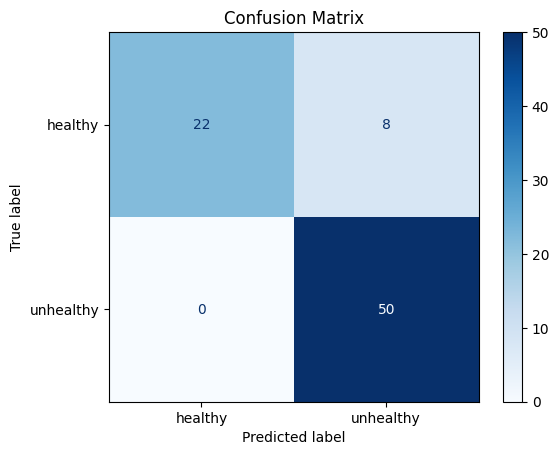

In [18]:
# Построение матрицы путаницы
conf_matrix = confusion_matrix(results_df['TrueClass'], results_df['PredClass'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['healthy', 'unhealthy'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Сохранение результатов в CSV
results_dir = '/kaggle/working/results'
os.makedirs(results_dir, exist_ok=True)
csv_path = os.path.join(results_dir, 'results.csv')
results_df.to_csv(csv_path, index=False)

# Вывод результата
print(f'Результаты сохранены в {csv_path}')

Результаты сохранены в /kaggle/working/results/results.csv


In [20]:
results_df.loc[results_df['TrueClass']!=results_df['PredClass']]

,Image,TrueClass,PredClass,Confidence
13,/kaggle/input/binary-coco-first-article/test/u...,0,1,0.978495
16,/kaggle/input/binary-coco-first-article/test/u...,0,1,0.999872
26,/kaggle/input/binary-coco-first-article/test/u...,0,1,0.861178
35,/kaggle/input/binary-coco-first-article/test/u...,0,1,0.973857
47,/kaggle/input/binary-coco-first-article/test/u...,0,1,0.874449
51,/kaggle/input/binary-coco-first-article/test/u...,0,1,0.999982
64,/kaggle/input/binary-coco-first-article/test/u...,0,1,0.998668
75,/kaggle/input/binary-coco-first-article/test/u...,0,1,0.995876
